We will simulate convergent beam electron diffraction (CBED) patterns for Dicalcium aluminium alumosilicate (http://www.crystallography.net/cod/1000048.html). This calculation ran in 22 seconds on my home 2 GB NVIDIA GTX 750 Ti and 5 min 22 seconds on my Intel i5 CPU.

In [12]:
import pyms
import numpy as np
import torch

# Get crystal
crystal = pyms.structure.fromfile('Structures/1000048.p1',temperature_factor_units='B')

# Quick plot of crystal
# crystal.quickplot()

# Grid size in pixels
gridshape = [1024,1024]

# Tile out grid to acceptable size
tiling = [32,32]

# Probe accelerating voltage in eV
eV = 3e5

# Probe forming aperture in mrad
app = 10

# Number of frozen phonon passes
nfph = 3

# Choose device to run calculation on (GPU or CPU)
# device = torch.device('cpu')
device = torch.device('cpu')

subslices = [0.33, 0.66, 1.0]

# Set up thickness series (up to a 1000 Angstrom in steps of 100 Angstrom)
tstep = 100
thicknesses = np.arange(tstep,1001,tstep)
thicknesses = crystal.unitcell[2]
print(thicknesses)
    
output = pyms.HRTEM(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses = 204,
    subslices=subslices,
    tiling=tiling,
    nfph=nfph,
    nT = 5,
    showProgress=False,
    device_type=device,
)



5.0636
P.shape: torch.Size([4, 3, 1024, 1024])
P.shape: torch.Size([4, 3, 1024, 1024])
P.shape: torch.Size([4, 3, 1024, 1024])
P.shape: torch.Size([4, 3, 1024, 1024])
P.shape: torch.Size([4, 3, 1024, 1024])
[41]
0
41
T.shape:torch.Size([5, 3, 1024, 1024])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
0
41
T.shape:torch.Size([5, 3, 1024, 1024])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  

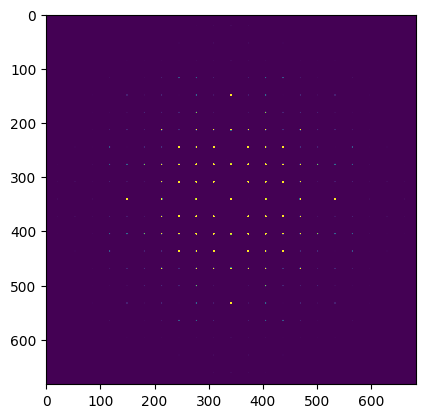

In [2]:

import matplotlib.pyplot as plt
plt.imshow(output, vmax = 100)

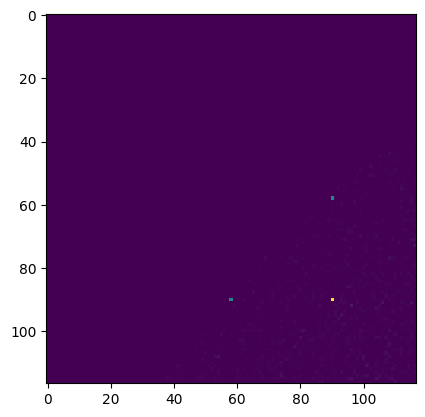

In [3]:
#Now plot results
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(output[27:144, 27:144]/np.sum(output[27:144, 27:144]), vmax = 0.05)

In [4]:
normalised_intensities = output/np.sum(output)

In [5]:
ints_refinement = np.load('/scratch-ssd/tiarty/data/28_06_23_AU_optimisation_data/001_Au_28_06_23.npy')

In [6]:
ints = normalised_intensities[ints_refinement[:,1].astype(int), ints_refinement[:,2].astype(int)]

In [7]:
Rbragg = (np.sum(np.abs(ints_refinement[:,0] - ints))/np.sum(np.abs(ints_refinement[:,0])))
Rbragg

0.9999497130224411

In [8]:
plt.imshow(output[0,:,:][27:144, 27:144]/np.sum(output[0,:,:][27:144, 27:144]), vmax = 0.01)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed